In [100]:
 %matplotlib inline

import numpy as np
from scipy.stats import rv_continuous, norm, truncnorm, arcsine, chi2, gamma, triang, entropy
from scipy.special import erf
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement
from time import time

class glove_distribution_gen(rv_continuous):
    def _pdf(self,x):
        conds = [x<0, (x>=0) & (x<1), (x>=1) & (x<3), (x>=3) & (x<4), x>4]
        funcs = [0, 0.7, 0, 0.3, 0]
        return np.piecewise(x, conds, funcs)
    def _cdf(self,x):
        conds = [x<0, (x>=0) & (x<1), (x>=1) & (x<3), (x>=3) & (x<4), x>4]
        funcs = [0, lambda x: 0.7*x, 0.7, lambda x: 0.7+0.3*(x-3), 1]
        return np.piecewise(x, conds, funcs)
    def _stats(self):
        return 1.4, 1.973333333333333, None, None
glove_distribution = glove_distribution_gen(name='glove_distribution')

gift_dist_list = [
    truncnorm(a=(0-5)/2, b=(50-5)/2, loc=5, scale=2),
    truncnorm((0-2)/0.3, (50-2)/0.3, loc=2, scale=0.3),
    truncnorm((0-20)/10, (50-10)/10, loc=20, scale=10),
    truncnorm((0-10)/5, (50-10)/5, loc=10, scale=5),
    arcsine(scale=47),
    chi2(2),
    gamma(5),
    triang(c = 1/3, loc=5, scale=15),
    glove_distribution]

gift_dists = {
    'horse' : truncnorm(a=(0-5)/2, b=(50-5)/2, loc=5, scale=2), #a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
    'ball'  : truncnorm((0-2)/0.3, (50-2)/0.3, loc=2, scale=0.3),
    'bike'  : truncnorm((0-20)/10, (50-10)/10, loc=20, scale=10),
    'train' : truncnorm((0-10)/5, (50-10)/5, loc=10, scale=5),
    'coal'  : arcsine(scale=47),
    'book'  : chi2(2),
    'doll'  : gamma(5),
    'blocks' : triang(c = 1/3, loc=5, scale=15),
    'gloves': glove_distribution
}

In [50]:
gift_types = ['horse', 'ball', 'bike', 'train', 'coal', 'book', 'doll', 'blocks', 'gloves']
gift_numbers = [1000, 1100, 500, 1000, 166, 1200, 1000, 1000, 200]
gift_ids = [[item +'_'+str(i) for i in range(gift_numbers[index])] for index, item in enumerate(gift_types)]
mean_weights = [gift_dists[i].mean() for i in gift_types]
var_weights = [gift_dists[i].var() for i in gift_types]

def plot_pdf(item, a, b, N):
    t = np.linspace(a, b, N)
    s = gift_dists[item].pdf(t)
    plt.plot(t, s)
    axes = plt.gca()

    if item == 'coal':
        ymin = 0
        ymax = 0.3
        axes.set_ylim([ymin,ymax])
    
    index = gift_types.index(item)
    entropy = entropy_list[index][1]
    number = gift_numbers[index]
    mean = mean_weights[index]
    var = var_weights[index]
    total_weight = mean*number
        
    plt.figtext(1, 0.7, "Mean: %.2f\nVariance: %.2f\nEntropy: %.2f\nNumber of items: %d\nTotal weight: %.2f" % 
                (mean, var,entropy, number,total_weight))
    
    plt.xlabel('weight (pounds)')
    plt.ylabel('PDF')
    plt.title(item)
    plt.grid(True)
    plt.show()
    
def plot_cdf(item, a, b, N):
    t = np.linspace(a, b, N)
    s = gift_dists[item].cdf(t)
    plt.plot(t, s)
    axes = plt.gca()

    index = gift_types.index(item)
    entropy = entropy_list[index][1]
    number = gift_numbers[index]
    mean = mean_weights[index]
    var = var_weights[index]
    total_weight = mean*number
        
    plt.figtext(1, 0.7, "Mean: %.2f\nVariance: %.2f\nEntropy: %.2f\nNumber of items: %d\nTotal weight: %.2f" % 
                (mean, var,entropy, number,total_weight))
    
    plt.xlabel('weight (pounds)')
    plt.ylabel('CDF')
    plt.title(item)
    plt.grid(True)
    plt.savefig("test.png")
    plt.show()

def my_entropy(func, a, b, N): #compute the discretized entropy in bits
    t = np.linspace(a, b, N)
    probs = func(t)
    zeroes = [i for i,x in enumerate(probs) if np.allclose(0, x)]    
    return entropy(pk=probs, base=2)

In [51]:
entropy_list = []
for key, value in gift_dists.items():
    ent_i = my_entropy(value.pdf, 0, 50, 1000)
    if ent_i == -np.inf: ent_i = np.inf
    print('The entropy of \'%s\' is: %f bits' % (key, ent_i))
    entropy_list.append([key, ent_i])
entropy_list.sort(key=lambda x:x[1])

The entropy of 'ball' is: 4.630615 bits
The entropy of 'train' is: 8.577619 bits
The entropy of 'horse' is: 7.327938 bits
The entropy of 'bike' is: 9.565264 bits
The entropy of 'book' is: 6.763217 bits
The entropy of 'coal' is: inf bits
The entropy of 'blocks' is: 7.948717 bits
The entropy of 'doll' is: 7.427448 bits
The entropy of 'gloves' is: 5.203219 bits


In [52]:
item = 'gloves'
entropy_list[0][1]

4.6306146687859515

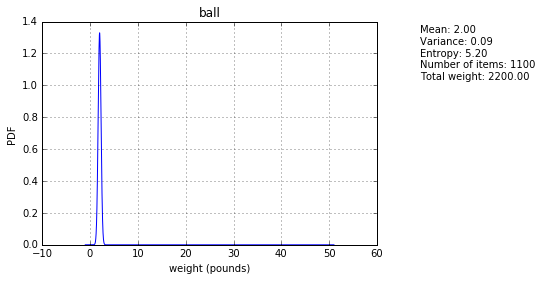

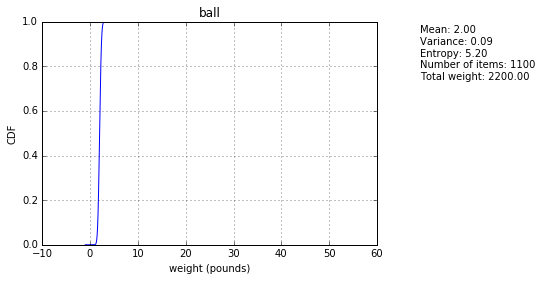

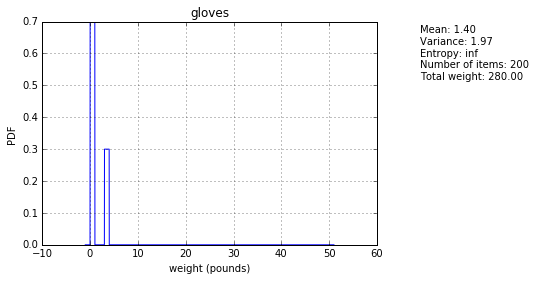

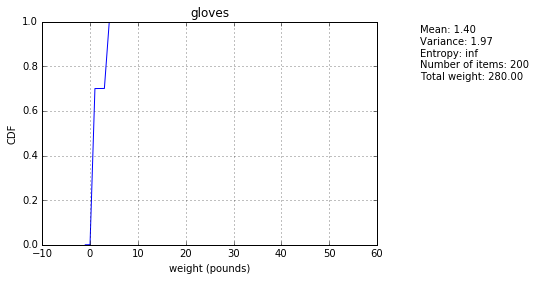

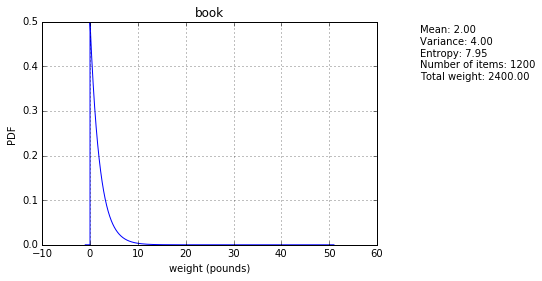

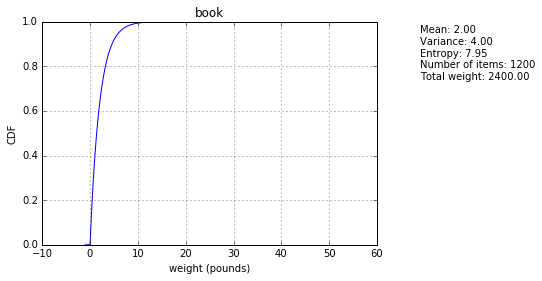

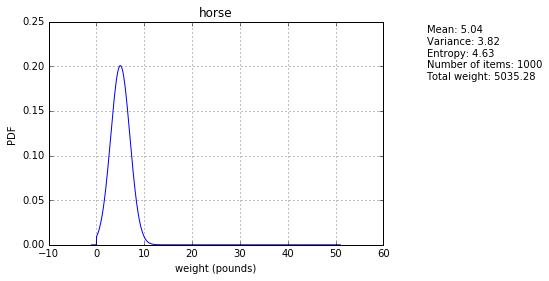

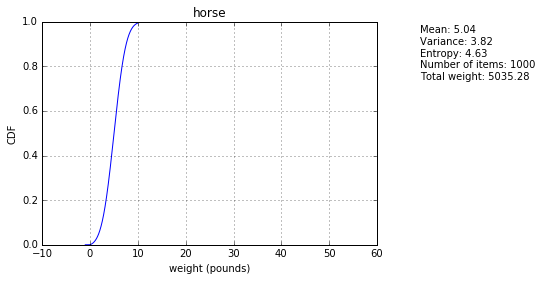

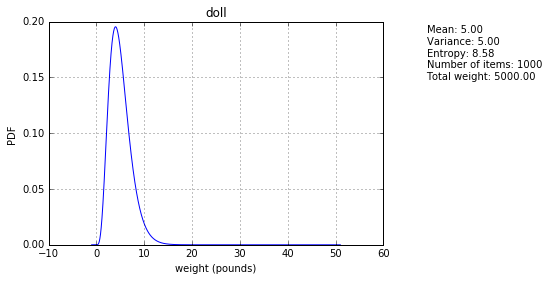

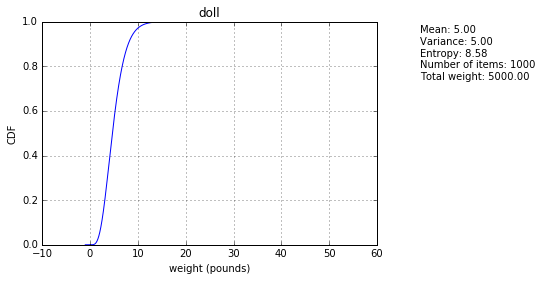

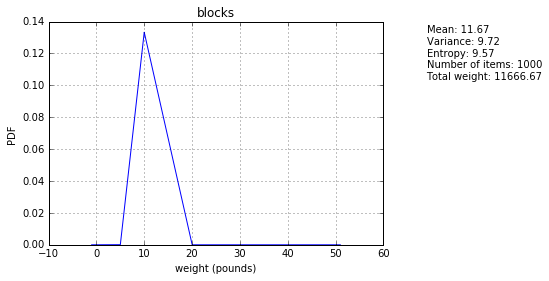

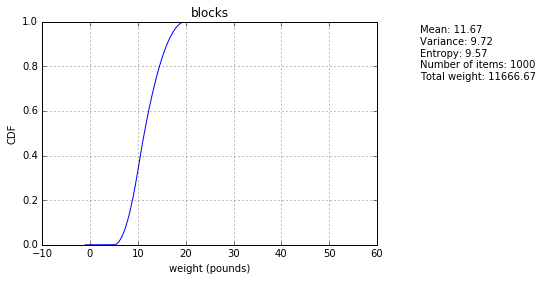

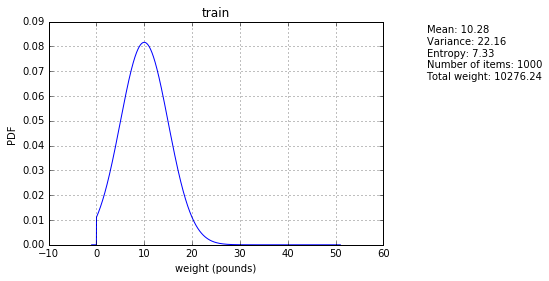

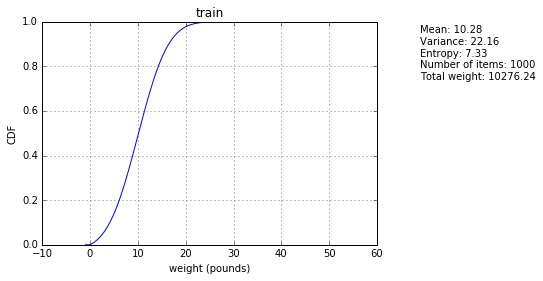

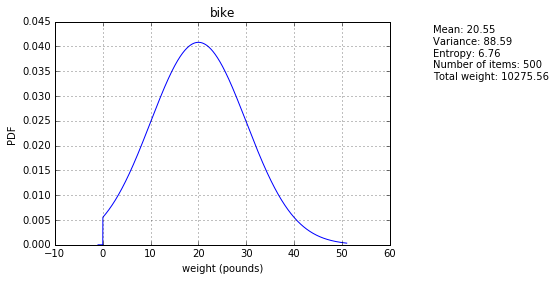

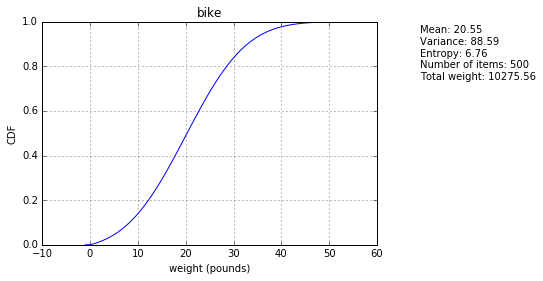

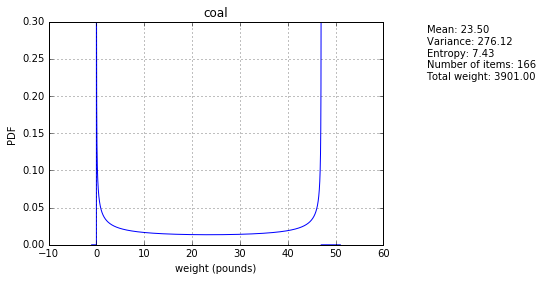

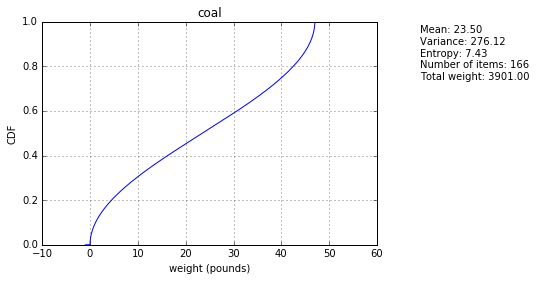

In [53]:
a = -1
b = 51
N = 1e6
for key, value in entropy_list:
    plot_pdf(key, a, b, N)
    plot_cdf(key, a, b, N)

In [111]:
def score(dist, lo, hi, N):
    x = np.linspace(lo,hi,N)
    y = dist.pdf(x)
    delta = x[1]-x[0]
    return sum(np.multiply(x,y))*delta

def truncnorm_mn(mean, std, clip_lo, clip_hi):
    return truncnorm(a=(clip_lo-mean)/std, b=(clip_hi-mean)/std, loc=mean, scale=std) #a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std

def best_mean(var, hi):
    return sqrt()

def plot_dist(dist, lo, hi, N, score_hi):
    t = np.linspace(lo, hi, N)
    s = dist.pdf(t)
    plt.plot(t, s)
    axes = plt.gca()

    if item == 'coal':
        ymin = 0
        ymax = 0.3
        axes.set_ylim([ymin,ymax])
    
    plt.figtext(1, 0.7, "Mean: %.2f\nVariance: %.2f\nScore: %.2f" % 
                (dist.mean(), dist.var(),score(dist,lo,score_hi,N)))
    
    plt.xlabel('weight (pounds)')
    plt.ylabel('PDF')
    plt.grid(True)
    plt.show()
    
def normal_score(mean, std, L):
    #returns the score for a normal variable for max weight = L
    return -(std/(np.exp((L - mean)**2/(2.*std**2))*np.sqrt(2*np.pi))) + (mean*(1 + erf((L - mean)/(np.sqrt(2)*std))))/2.

17.0614864749
17.021154392


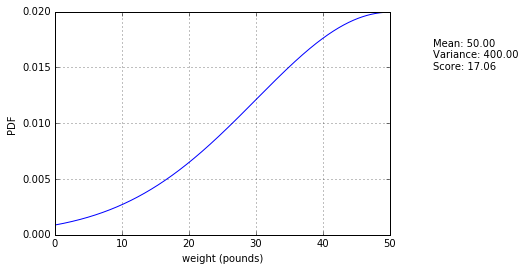

In [110]:
mean = 50
std = 20
lo = 0
hi = 50
L = 50
N = 100001

dist = norm(loc=mean, scale=std)
print(score(dist, lo, hi, N))
print(normal_score(mean,std,L))
plot_dist(dist, lo, hi, N, L)